In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [20]:
fh = pd.read_csv("~/Documents/Research/fetal_health.csv")

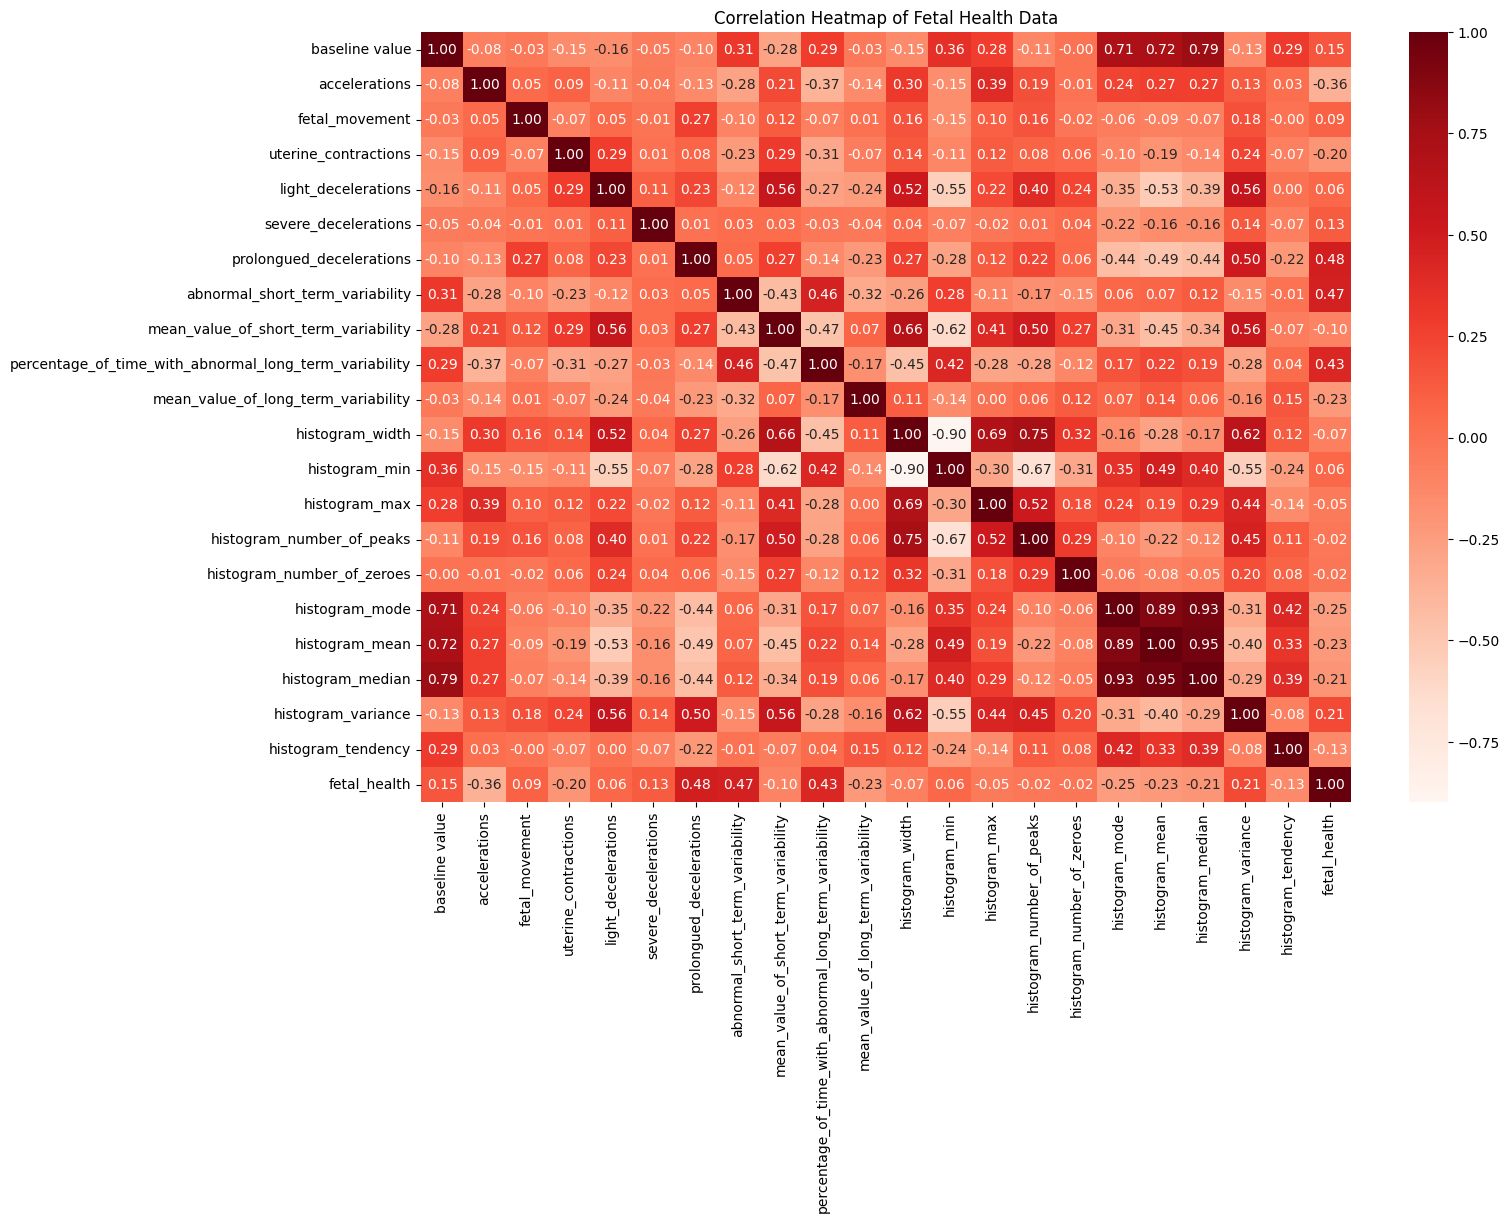

In [27]:
plt.figure(figsize=(15, 10))
sns.heatmap(fh.corr(), annot=True, cmap='Reds', fmt='.2f')
plt.title('Correlation Heatmap of Fetal Health Data')
plt.show()

### See the correlation to 'fetal_health' for each feature

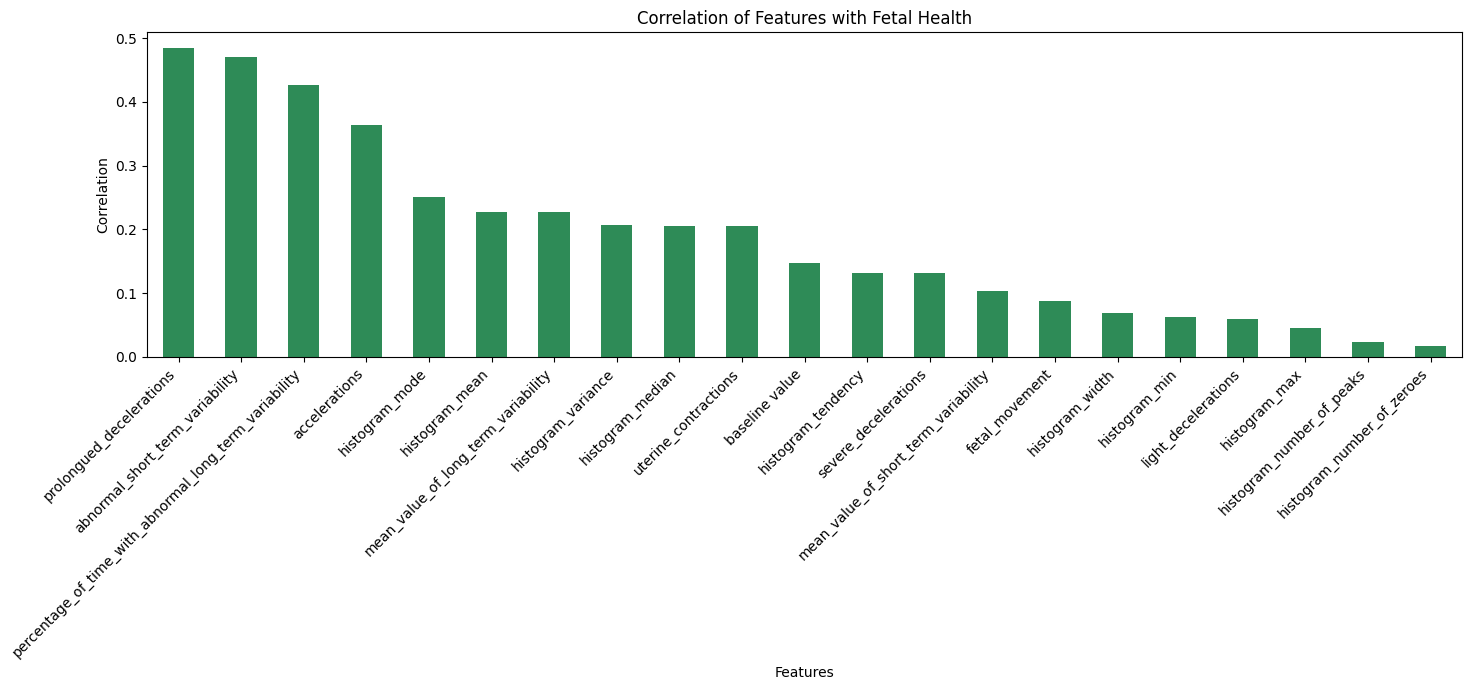

In [50]:
correlations = fh.corr()['fetal_health'].drop('fetal_health')
sorted_correlations = correlations.abs().sort_values(ascending=False)

plt.figure(figsize=(15, 7))
sorted_correlations.plot(kind='bar', color='seagreen')
plt.title('Correlation of Features with Fetal Health')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### See the count of the different outcomes

Text(0.5, 1.0, 'Count of fetal health data points')

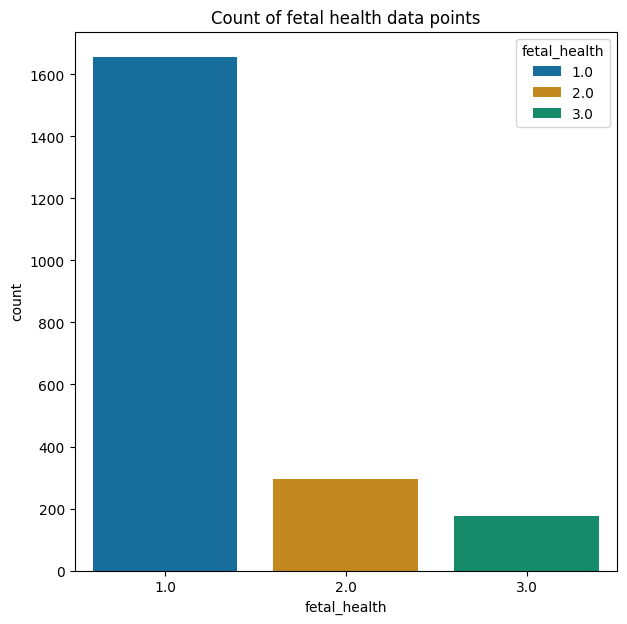

In [65]:
plt.figure(figsize=(7,7))
sns.countplot(x='fetal_health', data=fh, palette='colorblind', hue='fetal_health')
plt.title("Count of fetal health data points")

### Split the data into x and y

In [78]:
x = fh.drop(columns="fetal_health")
y = fh['fetal_health'] - 1 # subtract 1 so that lables start at 0 instead of 1
print(x.shape)
print(y.shape)

(2126, 21)
(2126,)


### split the data into test and training 20% for test

In [81]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### train the random forest model

In [82]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

### test the random forest model

In [83]:
y_pred = rf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9553990610328639


### lets see if we can get it better with hyper parameter optimization

In [84]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

rf1 = RandomForestClassifier()

# use random search to find the best hyperparameters
# this will train many models and will store the best one
rand_search = RandomizedSearchCV(rf1, param_distributions=param_dist, n_iter=5, cv=5)

rand_search.fit(x_train, y_train)

best_rf = rand_search.best_estimator_
print('Best hyperparameters: ', rand_search.best_params_)

Best hyperparameters:  {'max_depth': 18, 'n_estimators': 207}


### Results of the best hyperparameters

In [85]:
y_pred = best_rf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.960093896713615


### View the confusion matrix

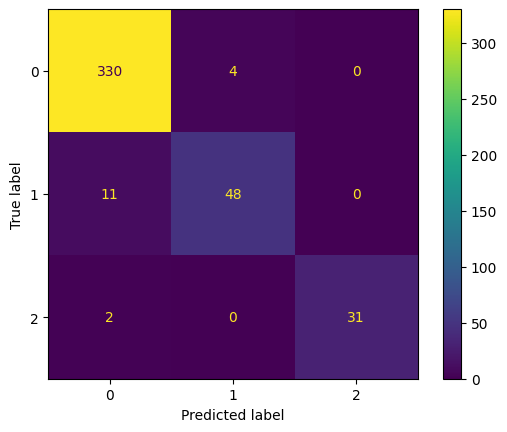

In [86]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

The model is accurate to 96%, but I think we can do even better. One example I saw balanced the dataset by adding synthetic points to the lables that do not have as many data points

In [88]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x,y)

print(y_resampled.value_counts())

fetal_health
1.0    1655
0.0    1655
2.0    1655
Name: count, dtype: int64


In [90]:
xr_train, xr_test, yr_train, yr_test = train_test_split(x_resampled, y_resampled, test_size=0.2)
rf_resampled = RandomForestClassifier()
rf_resampled.fit(xr_train, yr_train)

RandomForestClassifier()

In [94]:
yr_pred = rf_resampled.predict(xr_test)
accuracy = accuracy_score(yr_test, yr_pred)
print("accuracy: ", accuracy)

accuracy:  0.9788519637462235


look at the feature importance what each feature contributes to the model

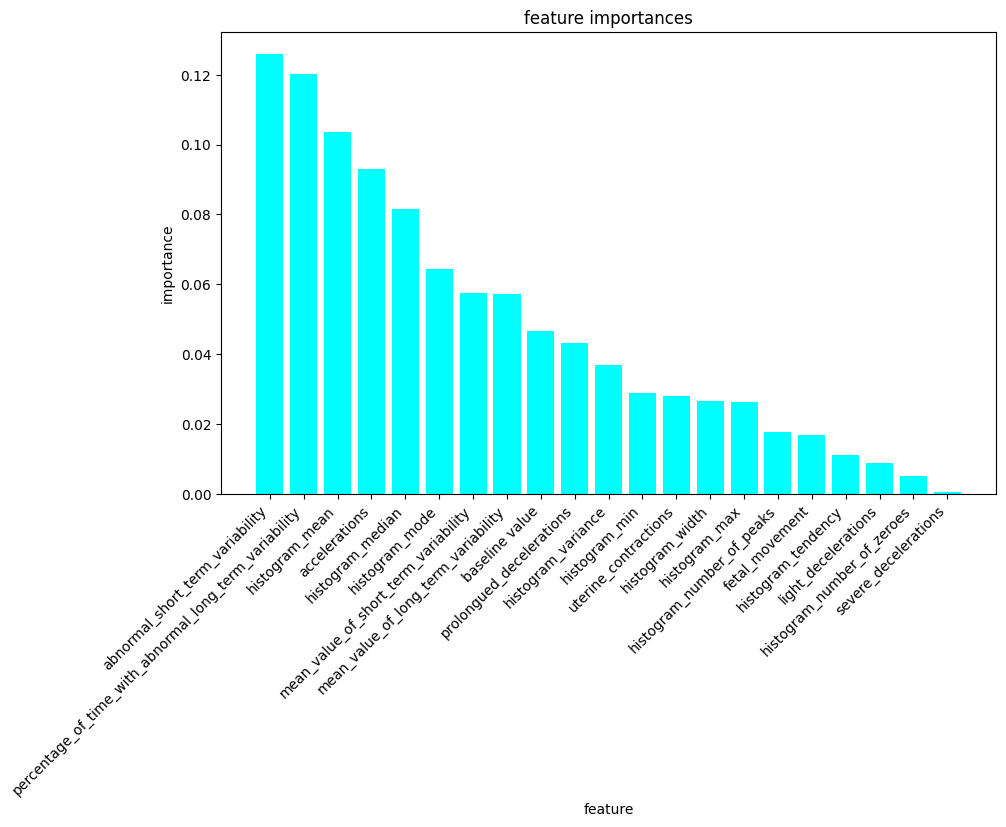

In [107]:
feature_importances = rf_resampled.feature_importances_
feature_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': feature_importances
})
feature_df = feature_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.bar(feature_df['Feature'], feature_df['Importance'], color='cyan')
plt.title("feature importances")
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(rotation=45, ha='right')
plt.show()